In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

source_dir = '/content/gdrive/MyDrive/XRAY/data/test' # Caminho corrigido com base na listagem do Google Drive
dest_dir = '/tmp/XRAY'

# Create the destination directory if it doesn't exist
!mkdir -p {dest_dir}

# Copy the contents of the source directory to the destination directory
!cp -r {source_dir}/* {dest_dir}/

print(f"Contents of '{source_dir}' copied to '{dest_dir}'")
print(f"Files in {dest_dir}: {os.listdir(dest_dir)}")

Contents of '/content/gdrive/MyDrive/XRAY/data/test' copied to '/tmp/XRAY'
Files in /tmp/XRAY: ['tuberculosis', 'normal', 'pneumonia']


In [ ]:
!ls /tmp/XRAY

normal	pneumonia  tuberculosis


In [ ]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import densenet169
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import copy
from contextlib import nullcontext

def _amp_available_for_device(device_type: str) -> bool:
    if device_type == 'cuda':
        return hasattr(torch.cuda, 'amp')
    return hasattr(torch, 'amp') and hasattr(torch.amp, 'autocast') and hasattr(torch.amp, 'GradScaler')


def _build_grad_scaler(device_type: str, enabled: bool):
    if not enabled:
        return None
    if device_type == 'cuda' and hasattr(torch.cuda, 'amp'):
        return torch.cuda.amp.GradScaler(enabled=True)
    if hasattr(torch, 'amp') and hasattr(torch.amp, 'GradScaler'):
        return torch.amp.GradScaler(device=device_type, enabled=True)
    return None


def _autocast_context(device_type: str, enabled: bool):
    if not enabled:
        return nullcontext()
    if device_type == 'cuda' and hasattr(torch.cuda, 'amp'):
        return torch.cuda.amp.autocast(enabled=True)
    if hasattr(torch, 'amp') and hasattr(torch.amp, 'autocast'):
        return torch.amp.autocast(device_type=device_type, enabled=True)
    return nullcontext()

class EarlyStopping:
    """
    Para o treinamento se a perda de validação não melhorar após um determinado número de epoches.
    """
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to: {self.counter}."
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epoches (Best: {self.best_loss:.4f})."
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epoches."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

class DataLoaders:
    def __init__(self,
                image_size=512,
                train_folder='/tmp/XRAY/data/train',
                val_folder='/tmp/XRAY/data/val',
                test_folder='/tmp/XRAY/data/test',
                batch_size=32,
                device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                default_num_workers=max(1, (os.cpu_count() or 1) // 2),
                default_pin_memory=True
                ):
        self.image_size = image_size
        self.train_folder = train_folder
        self.val_folder = val_folder
        self.test_folder = test_folder
        self.batch_size = batch_size
        self.num_workers = int(default_num_workers)
        self.pin_memory = bool(default_pin_memory)
        self.device = device
        if str(device) == 'cuda':
            torch.backends.cudnn.benchmark = True

    def _build_transforms(self):

        train_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((self.image_size, self.image_size)),
            transforms.RandomEqualize(),
            transforms.RandomRotation(degrees=5),
            transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.25]),
        ])

        eval_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.25]),
        ])
        return train_transforms, eval_transforms

    def get_dataloaders(self):
        """
        Cria os DataLoaders para treino, validação e teste usando ImageFolder.
        """
        train_transforms, eval_transforms = self._build_transforms()

        train_set = ImageFolder(root=self.train_folder, transform=train_transforms)
        val_set = ImageFolder(root=self.val_folder, transform=eval_transforms)
        test_set = ImageFolder(root=self.test_folder, transform=eval_transforms)

        train_dl = DataLoader(
            dataset=train_set,
            shuffle=True,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )

        val_dl = DataLoader(
            dataset=val_set,
            shuffle=False,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )


        test_dl = DataLoader(
            dataset=test_set,
            shuffle=False,
            batch_size= self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )

        return train_dl, val_dl, test_dl




class DenseNet161Modified(nn.Module):
    def __init__(self):
        super(DenseNet161Modified, self).__init__()
        self.densenet = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1)
        conv0 = self.densenet.features.conv0
        new_conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            new_conv0.weight[:] = conv0.weight.mean(dim=1, keepdim=True)
        self.densenet.features.conv0 = new_conv0
        self.densenet.classifier = nn.Linear(in_features=1664, out_features=3)

    def show_sample_predictions(self, dataloader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), num_images=5):
        self.to(device)
        self.densenet.eval()
        images_shown = 0
        class_names = dataloader.dataset.classes

        plt.figure(figsize=(15, 5))
        with torch.inference_mode():
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = self.densenet(inputs)
                _, preds = torch.max(outputs, 1)

                for i in range(inputs.size(0)):
                    if images_shown >= num_images:
                        break
                    images_shown += 1
                    ax = plt.subplot(1, num_images, images_shown)
                    img = inputs[i].cpu().numpy().transpose((1, 2, 0))
                    img = img * 0.25 + 0.5
                    img = np.clip(img, 0, 1)
                    plt.imshow(img.squeeze(), cmap='gray')
                    ax.set_title(f'Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}')
                    ax.axis('off')
                if images_shown >= num_images:
                    break
        plt.show()

    def export_model(self, path):
        torch.save(self.densenet.state_dict(), path)
        print(f'Model exported to {path}')

    def load_model(self, path, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        self.densenet.load_state_dict(torch.load(path, map_location=device))
        self.densenet.to(device)
        print(f'Model loaded from {path}')

    def plot_metrics(self):
        train_losses, train_accuracies = zip(*self.train_metrics)
        val_losses, val_accuracies = zip(*self.val_metrics)

        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
        plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def train_model(self,
                    train_loader,
                    val_loader,
                    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                    learning_rate=1e-4,
                    patience=5,
                    num_epochs=100,
                    min_delta=0,
                    use_amp=None):
            self.train_metrics = []
            self.val_metrics = []
            all_layers = [name for name, _ in self.densenet.named_children()]
            all_layers.reverse()

            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                                mode='min',
                                                                factor=0.5,
                                                                patience=patience)
            if not isinstance(device, torch.device):
                device = torch.device(device)
            self.to(device)
            use_amp = torch.cuda.is_available() if use_amp is None else bool(use_amp)
            amp_device_type = device.type
            amp_supported = _amp_available_for_device(amp_device_type)
            amp_enabled = bool(use_amp and amp_supported)
            if use_amp and not amp_supported:
                print(f"AMP requested but not supported on '{amp_device_type}'. Continuing with full precision.")
            scaler = _build_grad_scaler(amp_device_type, amp_enabled)
            if amp_enabled and scaler is None:
                print("GradScaler is unavailable; disabling AMP for this run.")
                amp_enabled = False


            train_size = len(train_loader.dataset)
            val_size = len(val_loader.dataset)


            early_stopper = EarlyStopping(patience=patience,
                                          min_delta=min_delta,
                                          restore_best_weights=True)

            for epoch in range(num_epochs):
                print(f'Epoch {epoch + 1}/{num_epochs}')

                self.densenet.train()
                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in train_loader:
                    inputs = inputs.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)

                    optimizer.zero_grad(set_to_none=True)
                    with _autocast_context(amp_device_type, amp_enabled):
                        outputs = self.densenet(inputs)
                        loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, dim=1)
                    if amp_enabled and scaler is not None:
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        loss.backward()
                        optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels).item()

                train_epoch_loss = running_loss / train_size
                train_epoch_acc = running_corrects / train_size
                self.train_metrics.append((train_epoch_loss, train_epoch_acc))

                self.densenet.eval()
                val_loss = 0.0
                val_corrects = 0
                with torch.inference_mode():
                    for inputs, labels in val_loader:
                        inputs = inputs.to(device, non_blocking=True)
                        labels = labels.to(device, non_blocking=True)

                        with _autocast_context(amp_device_type, amp_enabled):
                            outputs = self.densenet(inputs)
                            loss = criterion(outputs, labels)

                        preds = torch.argmax(outputs, dim=1)

                        val_loss += loss.item() * inputs.size(0)
                        val_corrects += torch.sum(preds == labels).item()
                epoch_loss = val_loss / val_size
                epoch_acc = val_corrects / val_size
                self.val_metrics.append((epoch_loss, epoch_acc))

                scheduler.step(epoch_loss)

                print(f'Train: Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}\n'
                      f'Val: Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


                should_stop = early_stopper(self.densenet, epoch_loss)
                print(f"->{early_stopper.status}")
                if should_stop:
                    print(f"\nStopping the training earlier in the epoch {epoch + 1}.")
                    break

            print('========================Training complete=========================\n')


In [ ]:
neural_network = DenseNet161Modified()
train_loader, val_loader, test_loader = DataLoaders().get_dataloaders()
neural_network.train_model(train_loader, val_loader)
neural_network.export_model('/tmp/XRAY/densenet169_modifiedV4.pt')
from google.colab import files
files.download('/tmp/XRAY/densenet169_modifiedV4.pt')

Epoch 1/100


/tmp/ipython-input-2081829395.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler(enabled=True)
/tmp/ipython-input-2081829395.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=True)


Train: Loss: 0.4034 Acc: 0.7646
Val: Loss: 0.3474 Acc: 0.7751
->
Epoch 2/100
Train: Loss: 0.3480 Acc: 0.7777
Val: Loss: 0.4141 Acc: 0.7703
->No improvement in the last 1 epoches (Best: 0.3474).
Epoch 3/100
Train: Loss: 0.3406 Acc: 0.7767
Val: Loss: 0.3342 Acc: 0.7735
->Improvement found, counter reset to: 0.
Epoch 4/100
Train: Loss: 0.3337 Acc: 0.7778
Val: Loss: 0.3294 Acc: 0.7687
->Improvement found, counter reset to: 0.
Epoch 5/100
Train: Loss: 0.3316 Acc: 0.7750
Val: Loss: 0.3357 Acc: 0.7715
->No improvement in the last 1 epoches (Best: 0.3294).
Epoch 6/100
Train: Loss: 0.3362 Acc: 0.7759
Val: Loss: 0.3298 Acc: 0.7841
->No improvement in the last 2 epoches (Best: 0.3294).
Epoch 7/100
Train: Loss: 0.3244 Acc: 0.7772
Val: Loss: 0.3332 Acc: 0.7739
->No improvement in the last 3 epoches (Best: 0.3294).
Epoch 8/100
Train: Loss: 0.3327 Acc: 0.7798
Val: Loss: 0.3275 Acc: 0.7593
->Improvement found, counter reset to: 0.
Epoch 9/100
Train: Loss: 0.3249 Acc: 0.7800
Val: Loss: 0.3216 Acc: 0.76

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

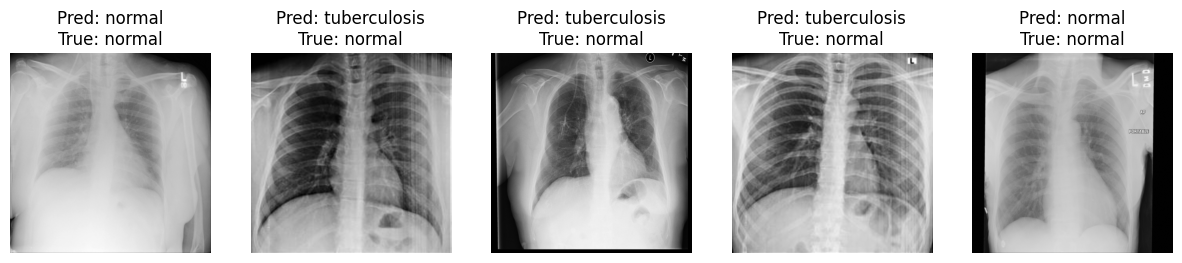

In [ ]:
neural_network.show_sample_predictions(test_loader, num_images=5)

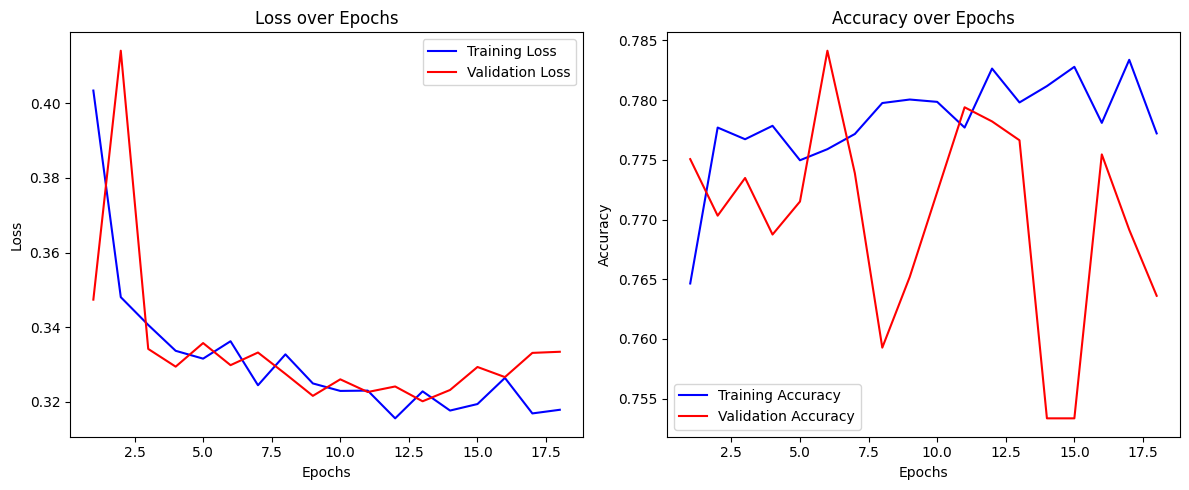

In [ ]:
neural_network.plot_metrics()

In [ ]:
neural_network = DenseNet161Modified()
neural_network.load_model('/content/gdrive/MyDrive/XRAY/densenet169_modifiedV4.pt')

Model loaded from /content/gdrive/MyDrive/XRAY/densenet169_modifiedV4.pt


In [ ]:
'''
Passar por cima da definição das classes pois minha unidades computacionais
estão acabando e não posso ficar com a sessão aberta importando arquivos para
armazenamento temporário.
'''

neural_network.densenet.eval()

image_size = 512
eval_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])

test_folder = '/tmp/XRAY'
batch_size = 32
num_workers = max(1, (os.cpu_count() or 1) // 2)
pin_memory = True

test_set = ImageFolder(root=test_folder, transform=eval_transforms)
test_loader = DataLoader(
    dataset=test_set,
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory
)

all_labels = []
all_preds = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.inference_mode():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = neural_network.densenet(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

class_names = test_loader.dataset.classes
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

      normal       0.92      0.38      0.54       925
   pneumonia       0.79      0.95      0.86       580
tuberculosis       0.71      1.00      0.83      1064

    accuracy                           0.77      2569
   macro avg       0.81      0.78      0.75      2569
weighted avg       0.81      0.77      0.74      2569



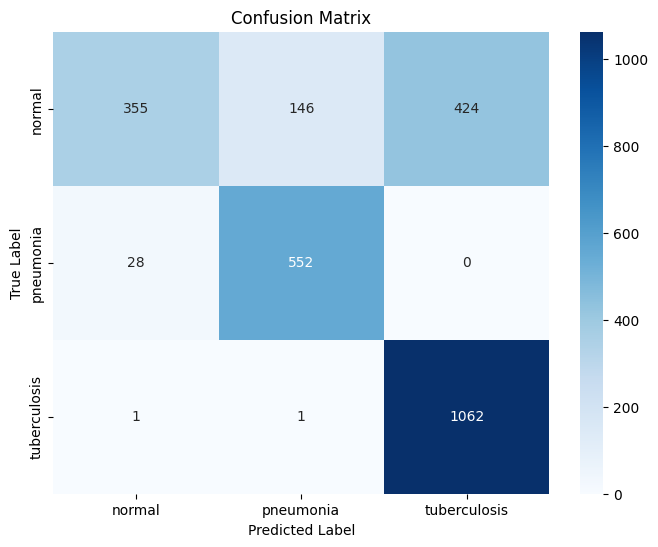

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch

neural_network.densenet.eval()

all_labels = []
all_preds = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.inference_mode():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = neural_network.densenet(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

class_names = test_loader.dataset.classes

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Future Prospects Based on Results

The current results demonstrate the model's strong ability to detect pneumonia and tuberculosis (high recall), which is excellent for a medical screening scenario. However, the low recall for the ‘Normal’ class and the more modest accuracy for ‘Tuberculosis’ indicate clear areas for optimization.

**Next Steps:**

1.  **Reduction of False Positives:** Investigate techniques to improve the classification of the ‘Normal’ class, such as resampling the dataset, weighting the loss function, or adjusting decision thresholds to minimize the false positive rate.
2.  **Robustness and Generalization:** Explore more aggressive data augmentation or ensemble models to increase the robustness and generalization ability of the model to a more diverse set of images.
3.  **Interpretability:** Apply interpretability techniques (e.g., Grad-CAM) to understand which regions of the images the model is focusing on, helping to diagnose possible biases or classification errors.
4.  **Fine-tuning with More Data:** If available, training with a larger and more diverse dataset can further refine the model's performance.

### Comparison of Accuracy and Recall by Class

Let's compare the accuracy and recall for each class based on the classification report:

*   **Normal (class 0):**
    *   **Accuracy: 0.92** - This means that when the model predicts ‘normal’, it is correct 92% of the time.
    *   **Recall: 0.38** - This means that only 38% of all actual ‘normal’ cases were correctly identified by the model. This is a relatively low recall, indicating that the model misses a significant portion of actual ‘normal’ cases, often misclassifying them as other categories.

*   **Pneumonia (class 1):**
*   **Accuracy: 0.79** - When the model predicts ‘pneumonia’, it is correct 79% of the time.
    * **Recall: 0.95** - The model successfully identified 95% of all actual cases of ‘pneumonia’. This is a very good recall, suggesting that the model is effective at finding most instances of pneumonia.

* **Tuberculosis (class 2):**
    *   **Accuracy: 0.71** - When the model predicts ‘tuberculosis’, it is correct 71% of the time.
*   **Recall: 1.00** - The model identified all (100%) actual cases of ‘tuberculosis’. This is an excellent recall.

**Summary:**
*   The model is very good at identifying cases of **Pneumonia** and **Tuberculosis**, as indicated by its high recall scores (0.95 and 1.00, respectively). This is crucial for medical diagnoses, where missing a positive case can be very serious.
*   However, the model struggles with the **Normal** class, presenting a low recall (0.38). This means that it often misclassifies normal cases as pneumonia or tuberculosis. This is also reflected in the accuracy of the ‘normal’ class, which is high, but only for the few cases that it actually predicts as ‘normal’.
* The accuracy for ‘tuberculosis’ is the lowest (0.71), even with perfect recall, suggesting that although it finds all cases of tuberculosis, some of its ‘tuberculosis’ predictions may actually be other conditions. The confusion matrix likely clarifies this further.

In essence, the model prioritizes the detection of positive cases (Pneumonia and Tuberculosis) over the correct identification of normal cases.